# TensorFlow 2.0

In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets 

import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter Tunning

In [2]:
num_epochs = 50
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32, 32, 3)
num_classes = 10

## Build Model

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, (3, 3), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2, 2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [4]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function 
              metrics=['accuracy'])  # Metrics / Accuracy

# Data Preprocess

In [5]:
train_paths = glob('../dataset/cifar/train/*.png')[:1000]
test_paths = glob('../dataset/cifar/test/*.png')[:1000]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png', '')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot)  # 이번에는 onehot이 아닌 label 번호로

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.  # rescale
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

## Training
- model.fit_generator를 history에 담아줘야함

http://localhost:6006

In [14]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

C:\Users\jumin\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
31/31 [==============================] - 11s 250ms/step - loss: 2.3310 - accuracy: 0.0971 - val_loss: 2.3021 - val_accuracy: 0.0897
Epoch 2/50
31/31 [==============================] - 8s 256ms/step - loss: 2.2945 - accuracy: 0.1240 - val_loss: 2.2797 - val_accuracy: 0.1633
Epoch 3/50
31/31 [==============================] - 7s 244ms/step - loss: 2.2333 - accuracy: 0.1767 - val_loss: 2.1885 - val_accuracy: 0.1986
Epoch 4/50
31/31 [==============================] - 8s 245ms/step - loss: 2.2078 - accuracy: 0.1787 - val_loss: 2.1726 - val_accuracy: 0.2157
Epoch 5/50
31/31 [==============================] - 7s 239ms/step - loss: 2.1631 - accuracy: 0.2004 - val_loss: 2.0940 - val_accuracy: 0.2056
Epoch 6/50
31/31 [==============================] - 7s 243ms/step - loss: 2.1288 - accuracy: 0.2273 - val_loss: 2.0801 - val_accuracy: 0.2268
Epoch 7/50
31/31 [==============================] - 7s 241ms/step - loss: 2.1029 - accuracy: 0.2076 - val_loss: 2.0964 - val_accuracy: 0.2308
Epoch

# History 들여다 보기 

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 31}

In [17]:
new_model = history.model

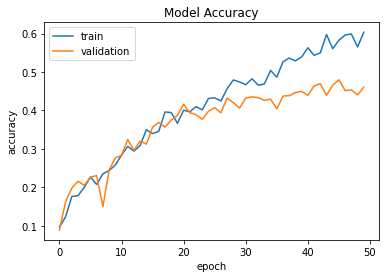

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

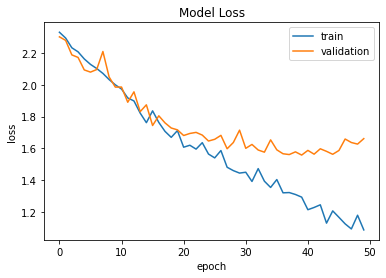

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## Predict

### 이미지를 직접 load해서 넣는 방법

In [21]:
path = test_paths[0]
path

'../dataset/cifar/test\\0_cat.png'

In [23]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile, dtype=tf.float32)
image.shape

TensorShape([32, 32, 3])

In [25]:
image = image[tf.newaxis, ...]
image.shape

TensorShape([1, 32, 32, 3])

In [28]:
pre = model.predict(image)
pre

array([[0.06890034, 0.03950035, 0.01393997, 0.15479487, 0.17380114,
        0.07429437, 0.01253017, 0.29074475, 0.01226205, 0.15923204]],
      dtype=float32)

In [29]:
pre.argmax()

7

### generator에서 데이터를 가져오는 방법

In [30]:
test_image, test_label = next(iter(test_dataset))
test_image.shape

TensorShape([32, 32, 32, 3])

In [34]:
pre = model.predict(test_image)
pre.shape

(32, 10)

In [43]:
pre.argmax(axis=-1)

array([7, 5, 0, 7, 4, 0, 1, 1, 8, 1, 6, 8, 0, 8, 7, 0, 3, 4, 1, 6, 0, 2,
       3, 1, 7, 0, 0, 8, 7, 4, 0, 6], dtype=int64)

### generator에 넣는 방법

In [40]:
pred = model.predict_generator(test_dataset.take(2))
pred.shape

(64, 10)

In [44]:
pred.argmax(axis=-1)

array([7, 5, 0, 7, 4, 0, 1, 1, 8, 1, 6, 8, 0, 8, 7, 0, 3, 4, 1, 6, 0, 2,
       3, 1, 7, 0, 0, 8, 7, 4, 0, 6, 6, 6, 3, 8, 6, 3, 6, 6, 6, 7, 2, 4,
       3, 5, 5, 5, 0, 0, 3, 4, 8, 1, 1, 1, 8, 6, 8, 6, 9, 5, 3, 6],
      dtype=int64)

## Evaluation 
- prediction과 달리 image와 label같이 넣음

In [47]:
evals = model.evaluate(test_image, test_label)

1/1 [==============================] - 0s 75ms/step - loss: 1.2026 - accuracy: 0.5938


In [48]:
evals

[1.2026145458221436, 0.59375]